## Setup

In [1]:
import os
import sys

root = os.path.dirname(os.getcwd())
sys.path.append(root)
sys.path.append(os.path.join(root, "src"))

In [2]:
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.synthetic_experiment import run_cv
from src.utils.parser import Parser

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
x = sns.color_palette("Set1")
palette = {"DML": x[0], "C-DML": x[1]}

In [5]:
opts = Parser.compare()
opts.data_type = 'synthetic'
opts.majority_s = 0.8
opts.dml_net = 'NonLinearNet'
opts.cdml_net = 'NonLinearNet'
opts.sync_dml_lr = 0.3
opts.n_exp = 100

The C-DML algorithm is details in our paper ([Coordinated Double Machine Learning](https://arxiv.org/abs/2206.00885)) and denoted as **Algorithm 2** is detailed below in code blocks. Due to multiprocessing package not working properly on IPython, the attached python file has all the code, and we show it here step by step.

```
def dml_theta_estimator(y: torch.Tensor, d: torch.Tensor, m_hat: torch.Tensor, l_hat: torch.Tensor) -> float:
    v_hat = d - m_hat
    u_hat = y - l_hat
    theta_hat = torch.mean(v_hat * u_hat) / torch.mean(v_hat * v_hat)
    return theta_hat.item()
```

```
def run_dml(opts, D1, D2, D2_a, D2_b, exp) -> Tuple[Dict, torch.Tensor, Dict]:
    preds = dict(theta=opts.real_theta, gamma=np.nan, exp=exp, method="DML")

    # Train on D1
    double_ml = DoubleMachineLearningPyTorch.init_from_opts(opts=opts)
    params = double_ml.fit_params(opts=opts)
    double_ml = double_ml.fit(train=D1, test=D2, **params)

    # Predict theta on D2_a
    m_hat, l_hat = double_ml.predict(D2_a["x"])
    theta_init = dml_theta_estimator(y=D2_a["y"], d=D2_a["d"], m_hat=m_hat, l_hat=l_hat)
    u_hat, v_hat = D2_a["y"] - l_hat, D2_a["d"] - m_hat
    stats = {
        "corr.abs": torch.mean(torch.absolute(u_hat * v_hat)).item(),
        "res_m.2": torch.mean(v_hat ** 2).item(),
        "res_l.2": torch.mean(u_hat ** 2).item()
    }

    # Predict g(X) on D2_b
    m_hat, l_hat = double_ml.predict(D2_b["x"])
    g_hat = l_hat - theta_init * m_hat

    # Predict final theta on D2
    m_hat, l_hat = double_ml.predict(D2["x"])
    dml_theta = dml_theta_estimator(y=D2["y"], d=D2["d"], m_hat=m_hat, l_hat=l_hat)
    preds["theta_hat"] = dml_theta
    preds["bias"] = dml_theta - opts.real_theta

    return preds, g_hat, stats
```

```
def run_cdml(opts: argparse.Namespace, D1, D2, D2_a, D2_b, exp, g_hat, dml_stats) -> Dict:
    results = []
    for gamma in opts.gammas:
        opts.sync_dml_start_gamma = gamma

        sync_dml = SYNChronizedDoubleMachineLearning.init_from_opts(opts=opts)
        params = sync_dml.fit_params(opts=opts, dml_stats=dml_stats)

        preds = dict(theta=opts.real_theta, gamma=gamma, exp=exp, method="C-DML")

        # Train on D1
        sync_dml = sync_dml.fit(train=D1, test=D2, **params)

        # Predict theta on D2_a
        m_hat, l_hat = sync_dml.predict(D2_a["x"])
        sync_dml_theta_for_cv = dml_theta_estimator(y=D2_a["y"], d=D2_a["d"], m_hat=m_hat, l_hat=l_hat)

        # Residual error on D2_b
        sync_dml_y_hat = g_hat + sync_dml_theta_for_cv * D2_b["d"]
        preds["y_res.2"] = torch.mean((D2_b["y"] - sync_dml_y_hat) ** 2).item()

        # Predict final theta on D2
        m_hat, l_hat = sync_dml.predict(D2["x"])
        sync_dml_theta = dml_theta_estimator(y=D2["y"], d=D2["d"], m_hat=m_hat, l_hat=l_hat)
        preds["theta_hat"] = sync_dml_theta
        preds["bias"] = sync_dml_theta - opts.real_theta

        results.append(preds)

    results = pd.DataFrame(results)
    results = results.sort_values(by="y_res.2", ascending=True)
    preds = results.iloc[0].squeeze().to_dict()

    return preds
```

```
def run_experiment(opts: argparse.Namespace, exp: int) -> Dict[str, Dict]:
    data = DataSynthetic.init_from_opts(opts, as_tensors=True)

    D1, D2 = data.generate(real_theta=opts.real_theta, train_size=0.5, seed=exp)
    D2_copy = {k: v.detach().clone() for k, v in D2.items()}
    D2_a, D2_b = data.__train_test__(x=D2_copy["x"], d=D2_copy["d"], y=D2_copy["y"], train_size=0.5, seed=exp)

    dml_results, g_hat, dml_stats = run_dml(opts, D1, D2, D2_a, D2_b, exp)
    cdml_results = run_cdml(opts, D1, D2, D2_a, D2_b, exp, g_hat, dml_stats)

    return {
        "dml_results": dml_results,
        "cdml_results": cdml_results,
    }
```

```
def run_cv(opts: argparse.Namespace) -> pd.DataFrame:

    pbar = tqdm(total=opts.n_exp, desc=f"running C-DML")

    def _update(*a):
        pbar.update()

    with Pool(processes=opts.n_processes) as pool:
        tasks = [
            pool.apply_async(run_experiment, args=(opts, i), callback=_update)
            for i in range(opts.n_exp)
        ]
        [task.wait() for task in tasks]
        results = [task.get() for task in tasks]

    pbar.close()

    results = [result["dml_results"] for result in results] + [result["cdml_results"] for result in results]
    return pd.DataFrame(results)
```

Below we run experiments with $\theta=0$ for increasing values of $\rho$. $\rho$ is the autoregression coefficient that controls how different features are correlated. The higher $\rho$ is - the more correlated the features are. **Section 3.3** in [1] details the synthetic data generation process.

In [6]:
rhos = (0.1, 0.5, 0.9)
opts.real_theta = 0.0
opts.gammas = [0.0, 1.0, 10., 100.]
opts.n_gammas = len(opts.gammas)

results0_df = pd.DataFrame()
for rho in rhos:

    opts_copy = copy.deepcopy(opts)
    opts_copy.ar_rho = rho

    results0_df_rho = run_cv(opts_copy)
    results0_df_rho["rho"] = rho
    results0_df = pd.concat([results0_df, results0_df_rho], ignore_index=True,)

running C-DML: 100%|██████████| 100/100 [22:12<00:00, 13.33s/it]


Repeating the process for $\theta=1$:

In [7]:
rhos = (0.1, 0.5, 0.9)
opts.real_theta = 1.0
opts.gammas = [0.0, 0.1, 0.5, 1.0, 1.5]
opts.n_gammas = len(opts.gammas)

results1_df = pd.DataFrame()
for rho in rhos:

    opts_copy = copy.deepcopy(opts)
    opts_copy.ar_rho = rho

    results1_df_rho = run_cv(opts_copy)
    results1_df_rho["rho"] = rho
    results1_df = pd.concat([results1_df, results1_df_rho], ignore_index=True,)

running C-DML: 100%|██████████| 100/100 [26:12<00:00, 15.73s/it]


The code below visualizes the results:

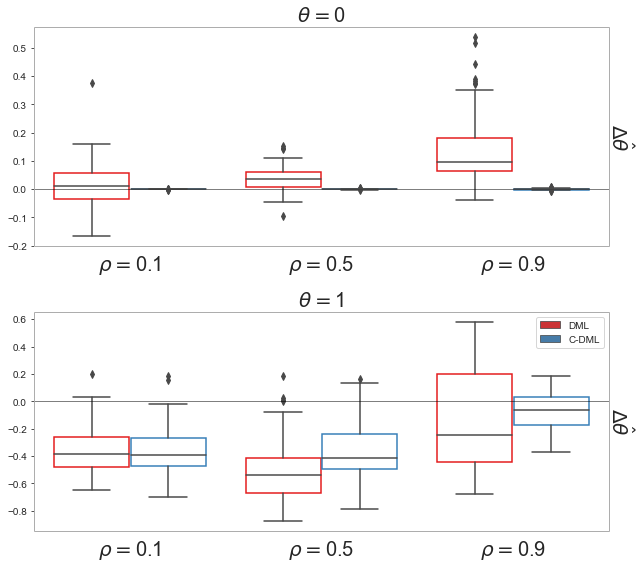

In [8]:
hue_order = ["DML", "C-DML"]
data = [(0.0, results0_df), (1.0, results1_df)]

with sns.axes_style("whitegrid"):
    _, axs = plt.subplots(len(data), 1, figsize=(9, 4 * len(data)))

    for ax, (theta, df) in zip(axs, data):

        boxplots = sns.boxplot(
            data=df,
            x="rho",
            y="bias",
            hue="method",
            hue_order=hue_order,
            palette=palette,
            ax=ax,
            linewidth=1.5,
            boxprops=dict(facecolor="none"),
        )

        for box, key in zip(boxplots.artists, len(rhos) * hue_order):
            box.set_edgecolor(palette[key])

        ax.set(facecolor="white")
        ax.axhline(y=0.0, linestyle="-", linewidth=0.5, color="black")
        ax.set_title(r"$\theta=$" + str(int(theta)), fontsize=20)
        ax.set_xticklabels([r"$\rho=$" + str(rho) for rho in rhos], fontsize=20)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend_.set_title(None)
        ax.grid(visible=False)

        ax_twin = ax.twinx()
        ax_twin.set_ylabel(r"$\Delta \hat{\theta}$", fontsize=20, rotation=270, labelpad=25)
        ax_twin.set_yticks([])
        ax_twin.set_yticklabels([])
        ax_twin.grid(visible=False)

    axs[0].get_legend().remove()

    for ax in axs:
        ax.spines["top"].set(visible=True, color="black")
        ax.spines["bottom"].set(visible=True, color="black")
        ax.spines["left"].set(visible=True, color="black")
        ax.spines["right"].set(visible=True, color="black")

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show();

The above figure shows the treatment estimation bias of DML and C-DML. In the case of $\theta=0$ which corresponds to a null hypothesis of no treatment effect, our purposed regularization $\mathcal{L}_b$ coincide with DML's bias term, $\mathcal{B}_{DML}$, and C-DML outperform DML. In the case of $\theta=1$, C-DML still achieves lower bias, due to the cross-validation process described in **Section 3.2** in [1].